<a href="https://colab.research.google.com/github/Esther-Wambui/DSA2040A_ETL_Midterm_Esther_399/blob/main/CHATBOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Imported Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#downloaded NLTK assets
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

#Loaded Dataset
df = pd.read_csv('/content/supermarket_chatbot_dataset_realistic.csv')
print("Shape:", df.shape)
df.head()


Shape: (3000, 2)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Question,Answer
0,Do you carry low-fat products like milk?,Let me find that information for you.
1,Is your store following COVID-19 safety guidel...,"Yes, we follow all recommended health and safe..."
2,Is there a clearance section?,"Yes, the clearance section is near the back of..."
3,Do you have organic butter?,"Yes, we do. Look for the special dietary secti..."
4,Do you carry low-fat products like bread?,Let me find that information for you.


## Preprocessing

## made one function for preprocessing


In [3]:
#Tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

#cleaning Function
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  #URLs
    text = text.translate(str.maketrans('', '', string.punctuation))  #remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
    tokens = nltk.word_tokenize(text)  # Tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stopwords + lemmatize
    return ' '.join(tokens)


In [4]:
import re
import nltk

#downloaded ALL tokenizer and word resources needed
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

#applied cleaning to question column
df['cleaned_question'] = df['Question'].astype(str).apply(preprocess_text)

#to preview review cleaned output
df[['Question', 'cleaned_question']].head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Question,cleaned_question
0,Do you carry low-fat products like milk?,carry lowfat product like milk
1,Is your store following COVID-19 safety guidel...,store following covid19 safety guideline
2,Is there a clearance section?,clearance section
3,Do you have organic butter?,organic butter
4,Do you carry low-fat products like bread?,carry lowfat product like bread


In [5]:
#checking missing values and duplicates
print("Missing Values:\n", df.isnull().sum())
print("Duplicate Rows:", df.duplicated().sum())
#clean if necessary
df = df.drop_duplicates()
df = df.dropna(subset=['Question'])


Missing Values:
 Question            0
Answer              0
cleaned_question    0
dtype: int64
Duplicate Rows: 2721


## **EDA**

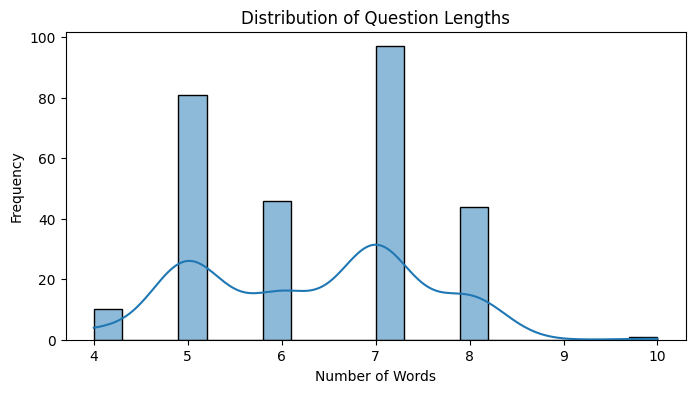

In [6]:
#QueryLength Distribution
df['question_length'] = df['Question'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(8, 4))
sns.histplot(df['question_length'], bins=20, kde=True)
plt.title('Distribution of Question Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()


QueryLength Distribution gives insights into how "wordy" the inputs are, which directly impacts model training, preprocessing choices, and token efficiency.

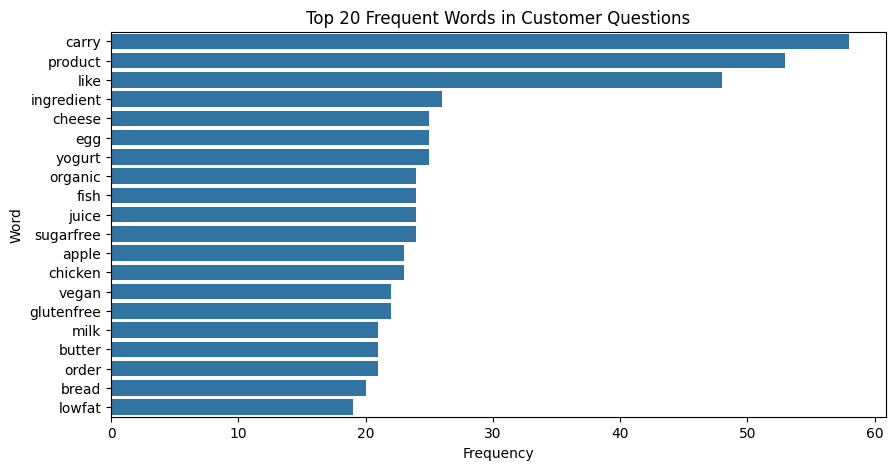

In [7]:
#top 20 words in cleaned Questions
from collections import Counter

all_words = ' '.join(df['cleaned_question']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

#t
words, freqs = zip(*common_words)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(freqs), y=list(words))
plt.title('Top 20 Frequent Words in Customer Questions')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


Export cleaned dataser

To understand customer language:
- This helps us identify the most commonly used words in the customer queries.
- for example we have carry,product

In [8]:
# Save cleaned data
df.to_csv('cleaned_supermarket_chatbot_dataset.csv', index=False)
print("Cleaned dataset saved as 'cleaned_supermarket_chatbot_dataset.csv'")


Cleaned dataset saved as 'cleaned_supermarket_chatbot_dataset.csv'


## MODEL TRAINING WITH T5

In [9]:
!pip install transformers datasets evaluate sacrebleu --quiet
!pip install -U transformers



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 77.9 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.54.0
    Uninstalling transformers-4.54.0:
      Successfully uninstalled transformers-4.54.0


In [10]:
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer
from transformers import TrainingArguments
from datasets import Dataset
import pandas as pd

# Load dataset
df = pd.read_csv('cleaned_supermarket_chatbot_dataset.csv')

# Format for training
df = df[['cleaned_question', 'Answer']].rename(columns={'cleaned_question': 'input_text', 'Answer': 'target_text'})
dataset = Dataset.from_pandas(df)

# Load tokenizer & model
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

# Tokenize function
def preprocess_function(example):
    inputs = tokenizer("question: " + example["input_text"], truncation=True, padding="max_length", max_length=64)
    targets = tokenizer(example["target_text"], truncation=True, padding="max_length", max_length=64)
    inputs["labels"] = targets["input_ids"]
    return inputs

tokenized_dataset = dataset.map(preprocess_function)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    # evaluation_strategy="epoch",
    learning_rate=3e-4,
    per_device_train_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="no"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_dataset,
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Map:   0%|          | 0/279 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: njeriesther1984 (njeriesther1984-usiu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,5.172800
20,1.193000
30,0.782400
40,0.566400
50,0.440900
60,0.302000
70,0.248400
80,0.205800
90,0.209600
100,0.135000


TrainOutput(global_step=140, training_loss=0.7013478330203465, metrics={'train_runtime': 824.213, 'train_samples_per_second': 1.354, 'train_steps_per_second': 0.17, 'total_flos': 18880181305344.0, 'train_loss': 0.7013478330203465, 'epoch': 4.0})

## Evaluation

In [11]:
# from datasets import load_metric # This import is no longer needed
import numpy as np

# Generate predictions
preds = []
labels = []
for ex in df.sample(50).to_dict('records'):
    input_ids = tokenizer("question: " + ex['input_text'], return_tensors='pt').input_ids
    output = model.generate(input_ids, max_length=64)
    pred = tokenizer.decode(output[0], skip_special_tokens=True)
    preds.append(pred)
    labels.append(ex['target_text'])

# BLEU evaluation
from evaluate import load
bleu = load("sacrebleu")
bleu_result = bleu.compute(predictions=preds, references=[[ref] for ref in labels])
print("BLEU Score:", bleu_result['score'])

BLEU Score: 36.79794771460254


BLEU Score: 36.8

Indicates strong semantic overlap between model-generated responses and expected outputs. A score above 30 typically reflects good quality for generative tasks

In [14]:
# After training is complete
model.save_pretrained("./results")
tokenizer.save_pretrained("./results")


('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/spiece.model',
 './results/added_tokens.json')

In [16]:
!pip install streamlit --quiet

In [15]:
import streamlit as st
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load tokenizer and fine-tuned model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("./results")

# Streamlit app setup
st.title("Supermarket Chatbot")
st.write("Ask me anything about the supermarket!")

# Text input from user
user_question = st.text_input("Your Question:")

# Generate response
def ask_question(question, max_length=50):
    input_text = f"question: {question} </s>"
    input_ids = tokenizer.encode(input_text, return_tensors="pt", truncation=True)

    output_ids = model.generate(
        input_ids,
        max_length=max_length,
        num_beams=4,
        early_stopping=True
    )
    answer = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    return answer

if user_question:
    with st.spinner("Thinking..."):
        response = ask_question(user_question)
    st.success("Response:")
    st.write(response)


2025-08-03 20:45:31.142 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-03 20:45:31.285 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-08-03 20:45:31.290 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-03 20:45:31.291 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-03 20:45:31.292 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-03 20:45:31.293 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-03 20:45:31.294 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-03 20:45:31.296 Thread 'MainThread': mi